The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


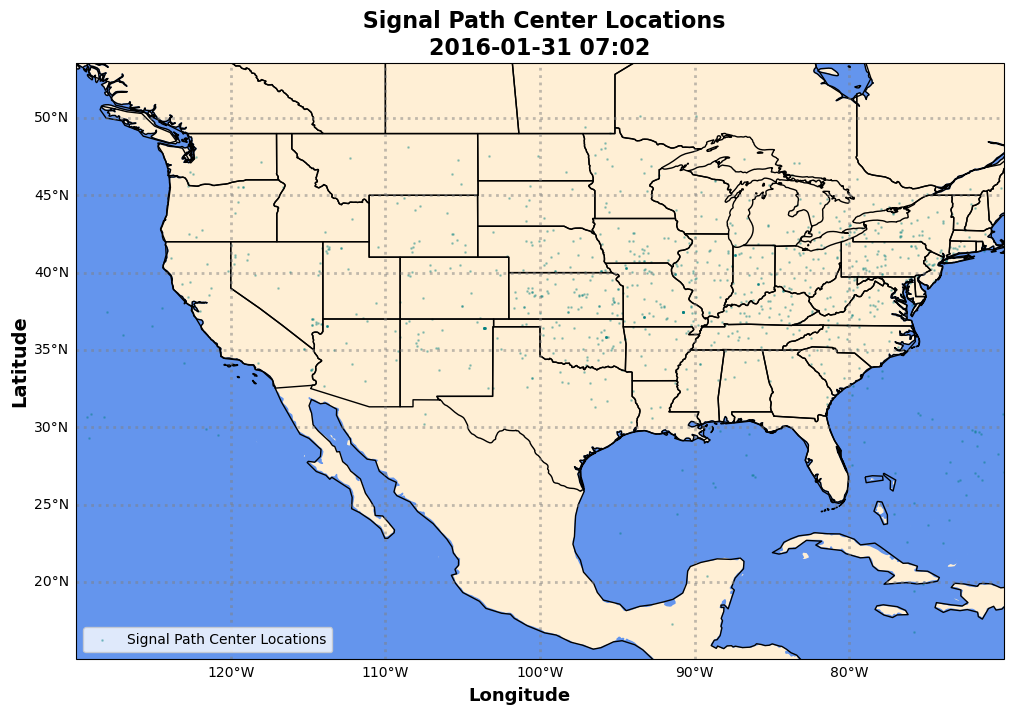

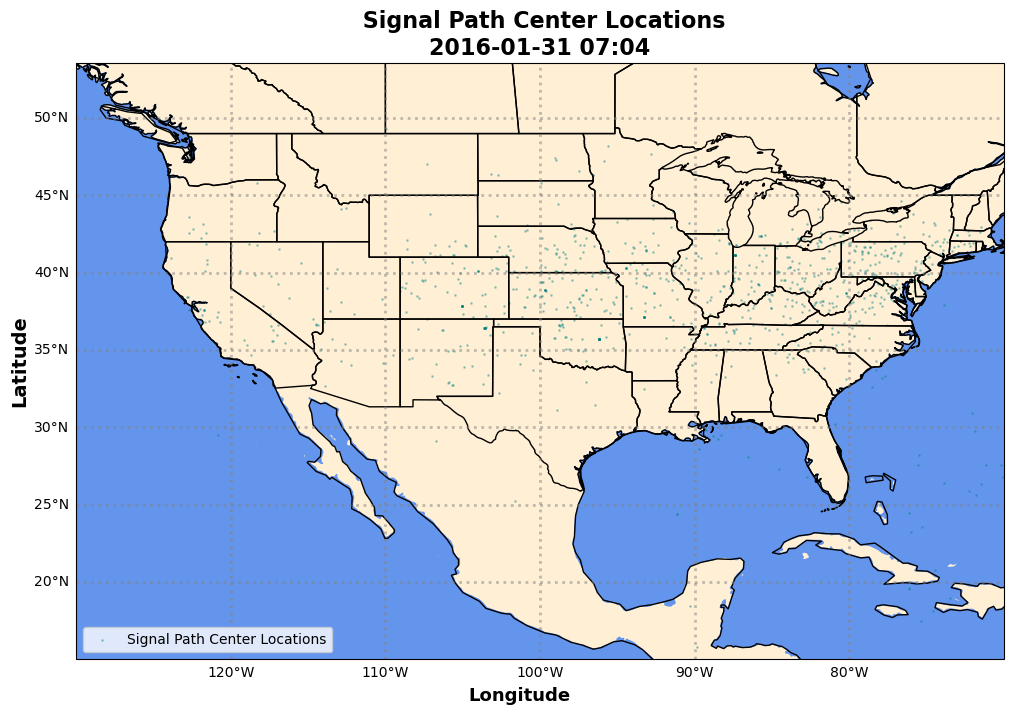

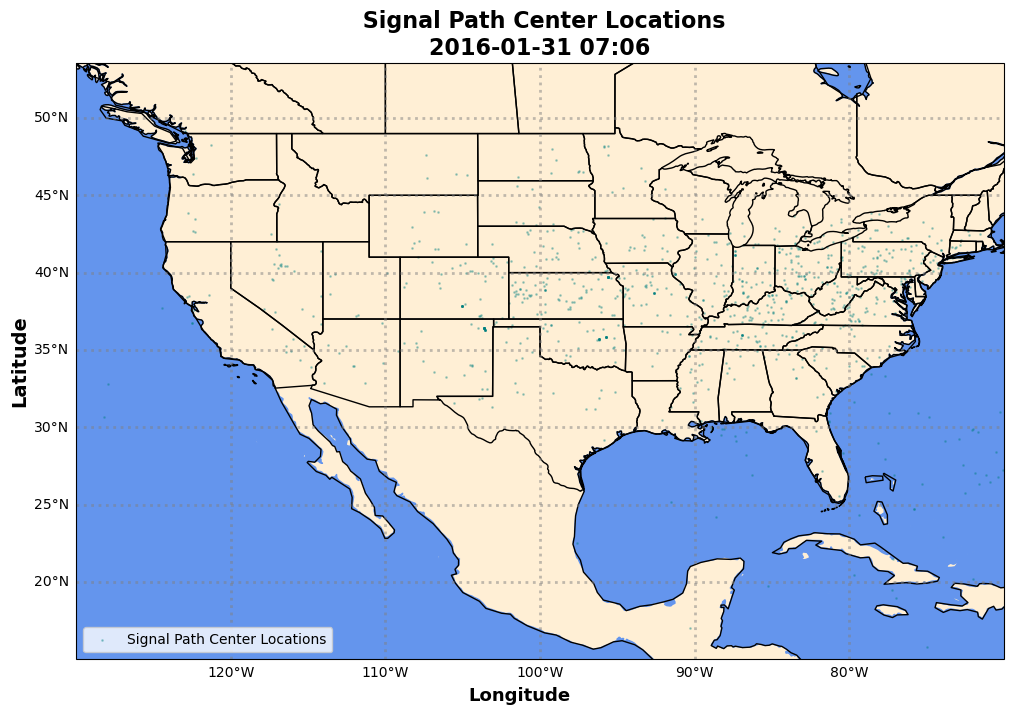

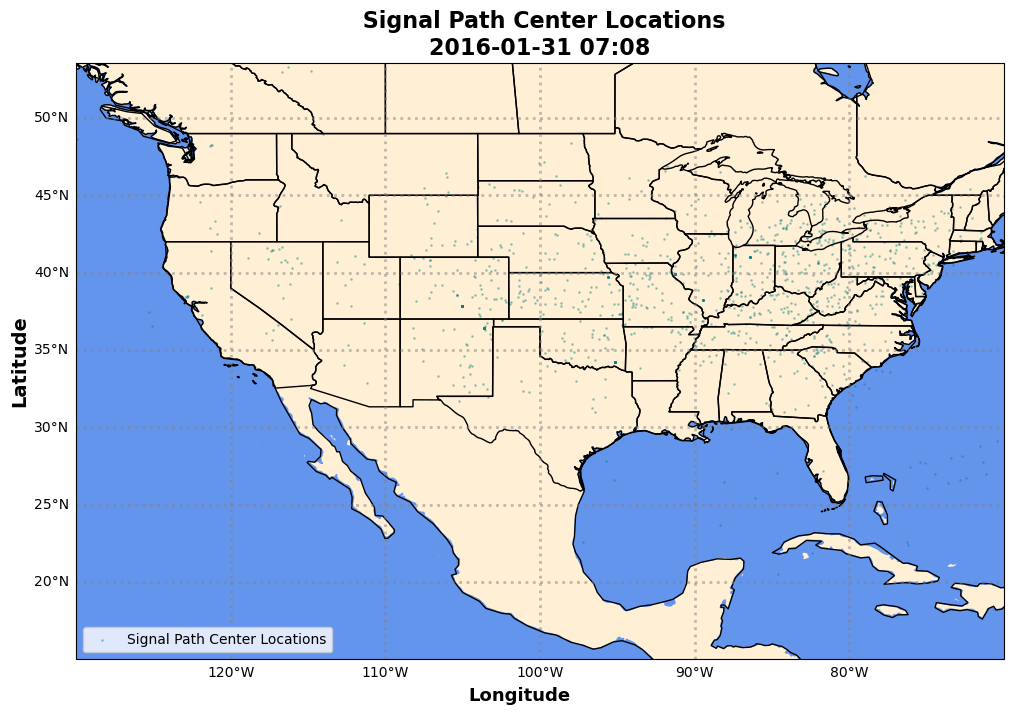

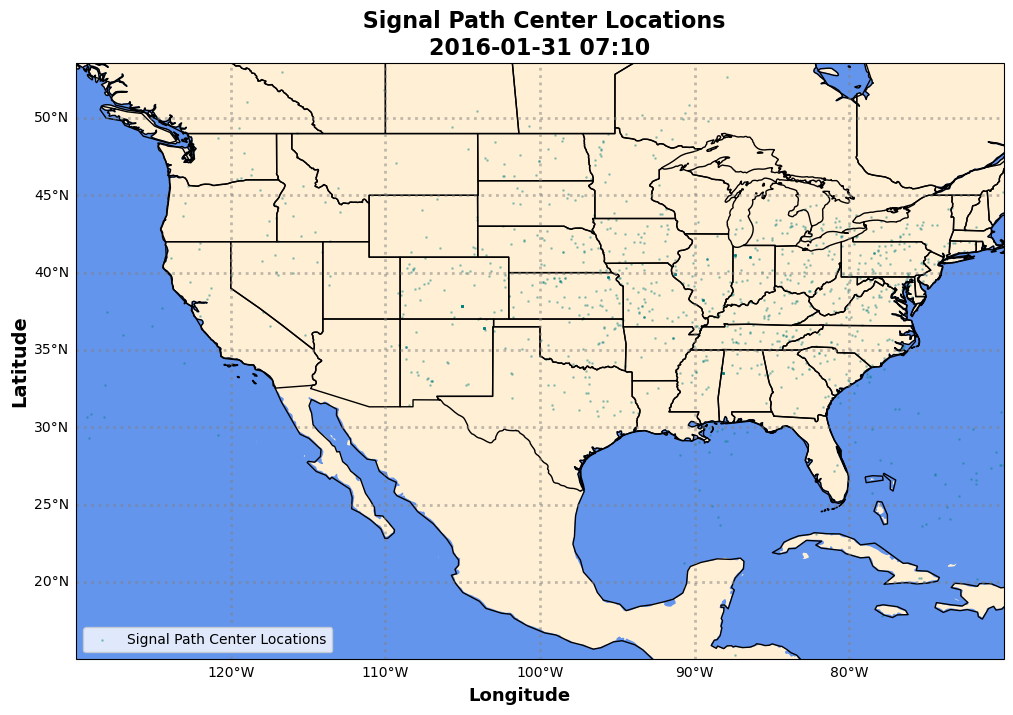

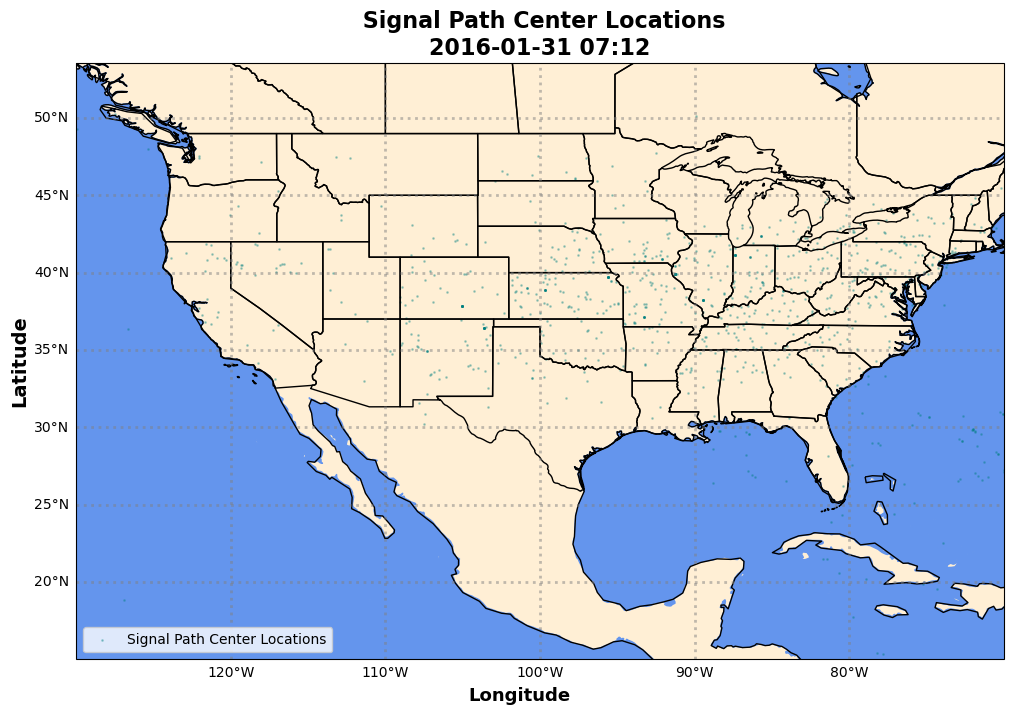

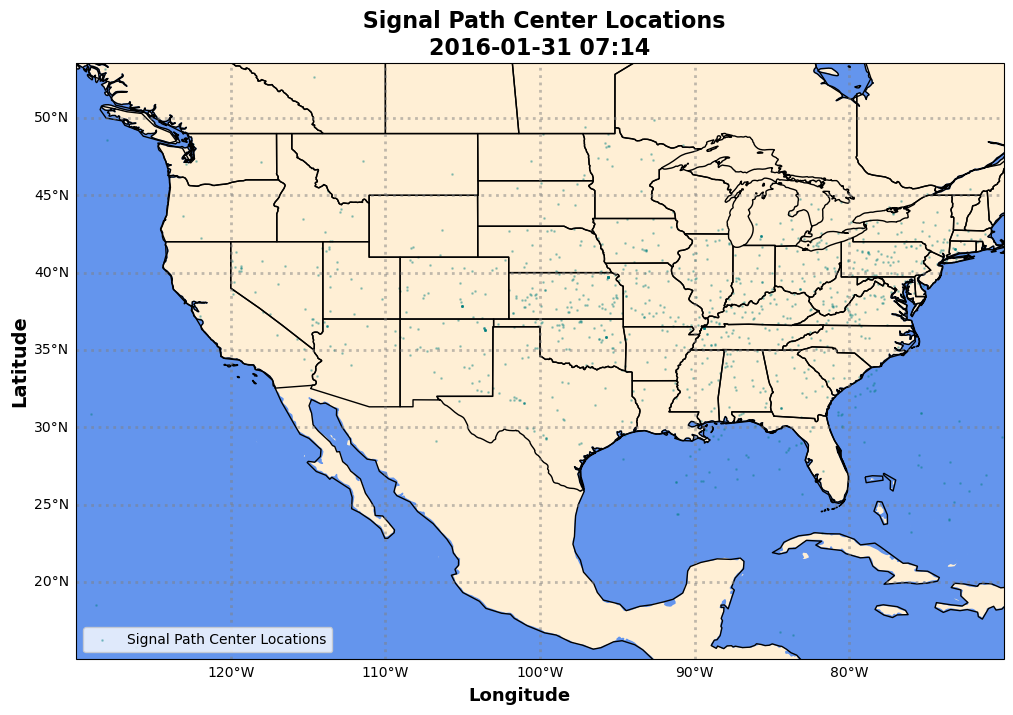

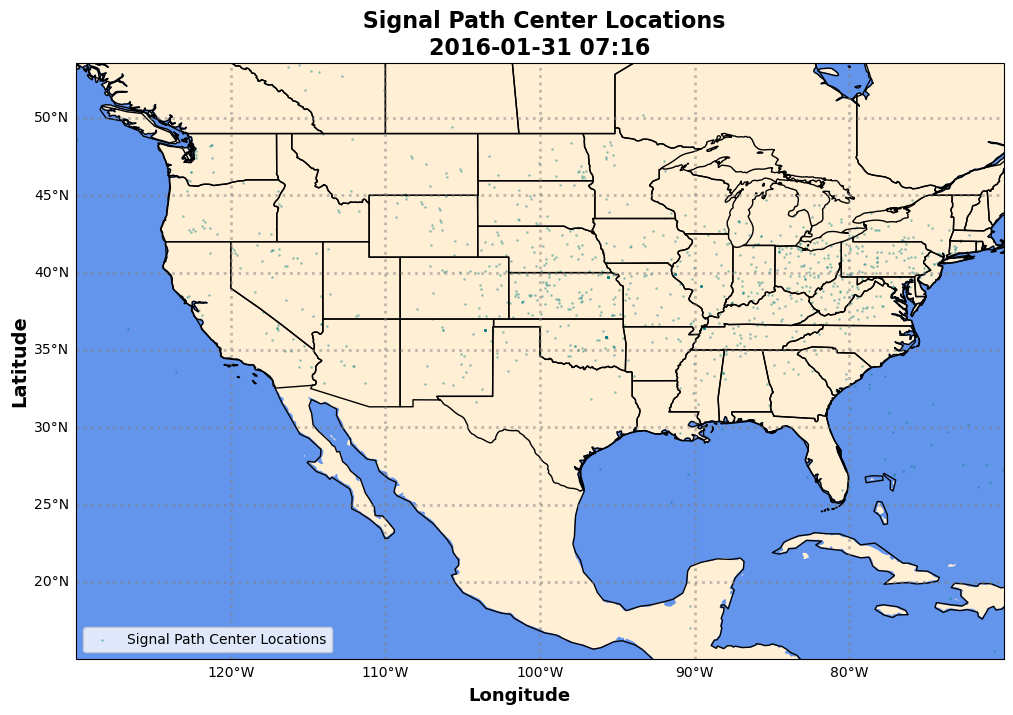

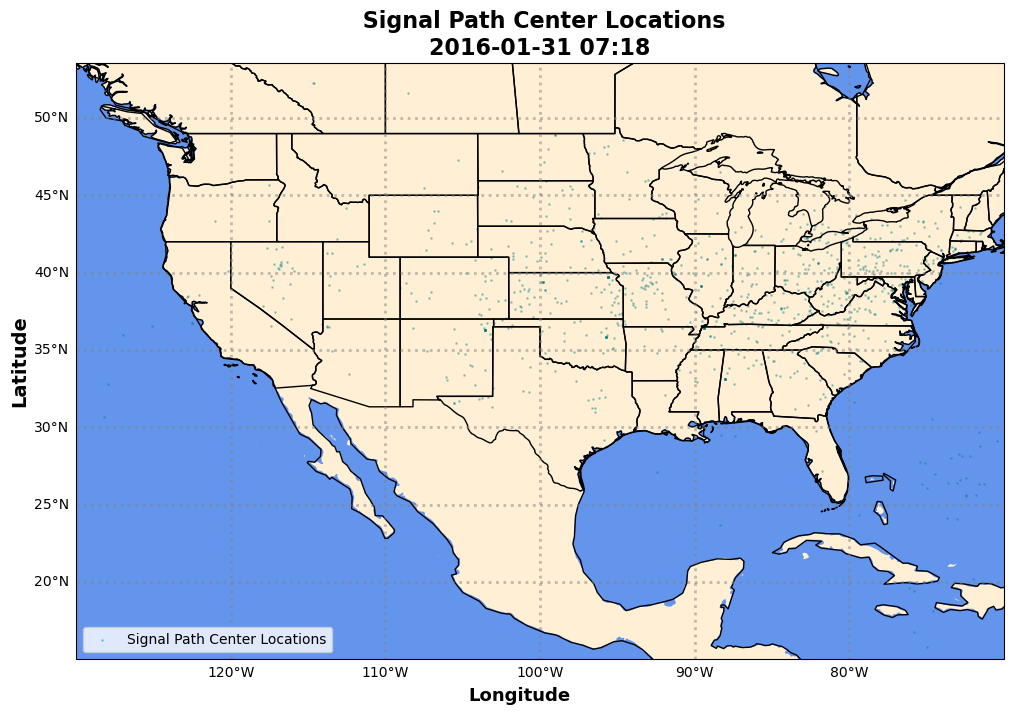

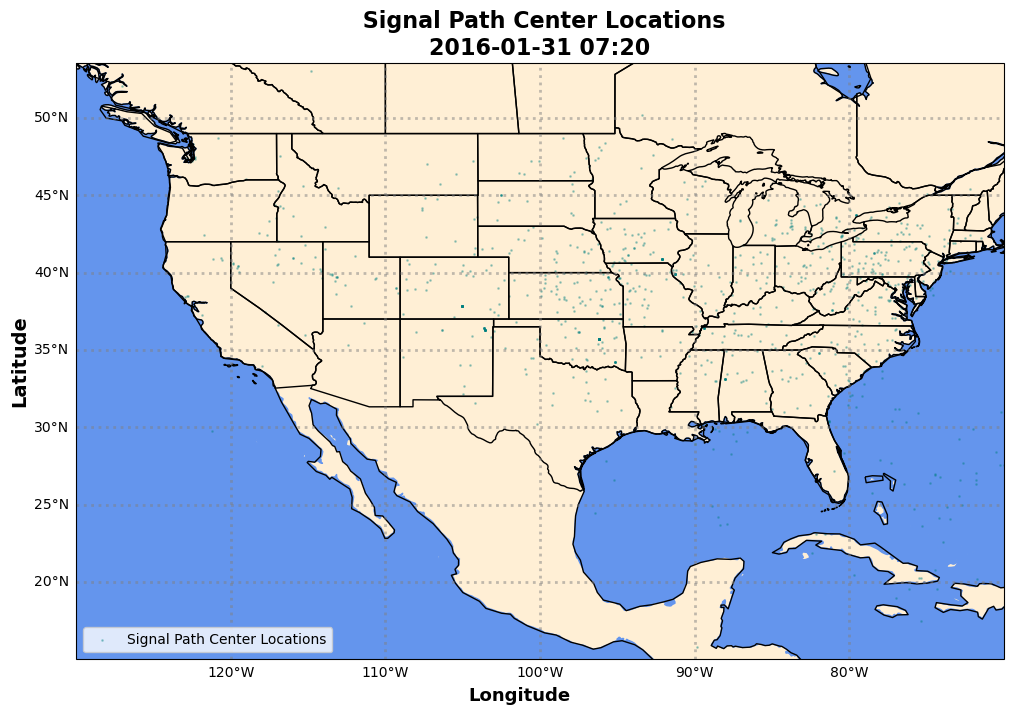

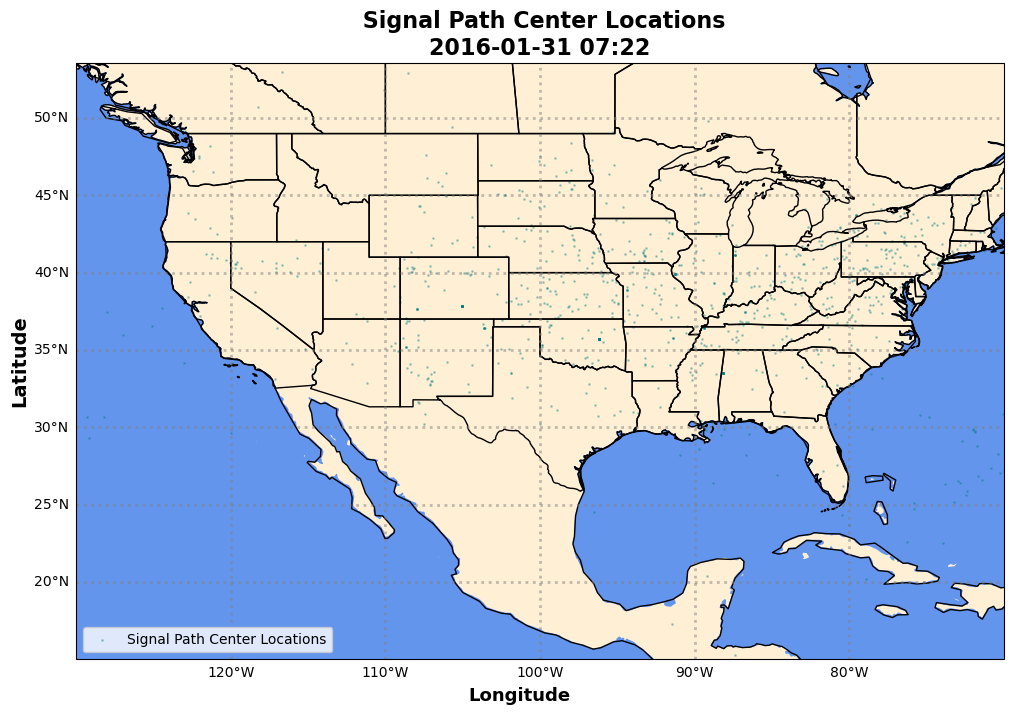

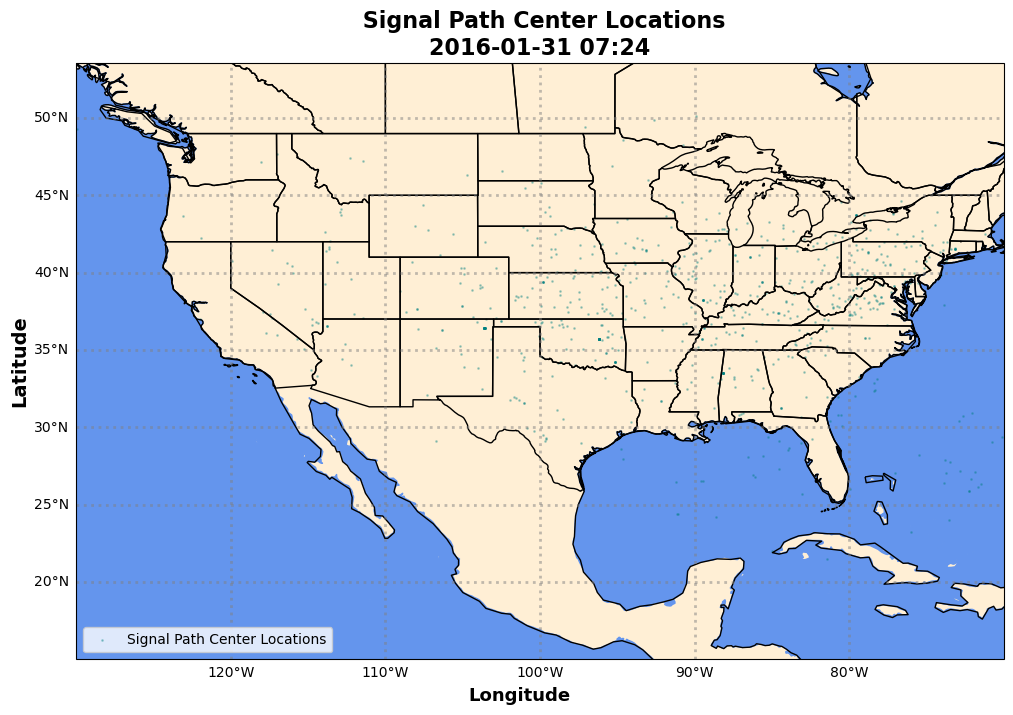

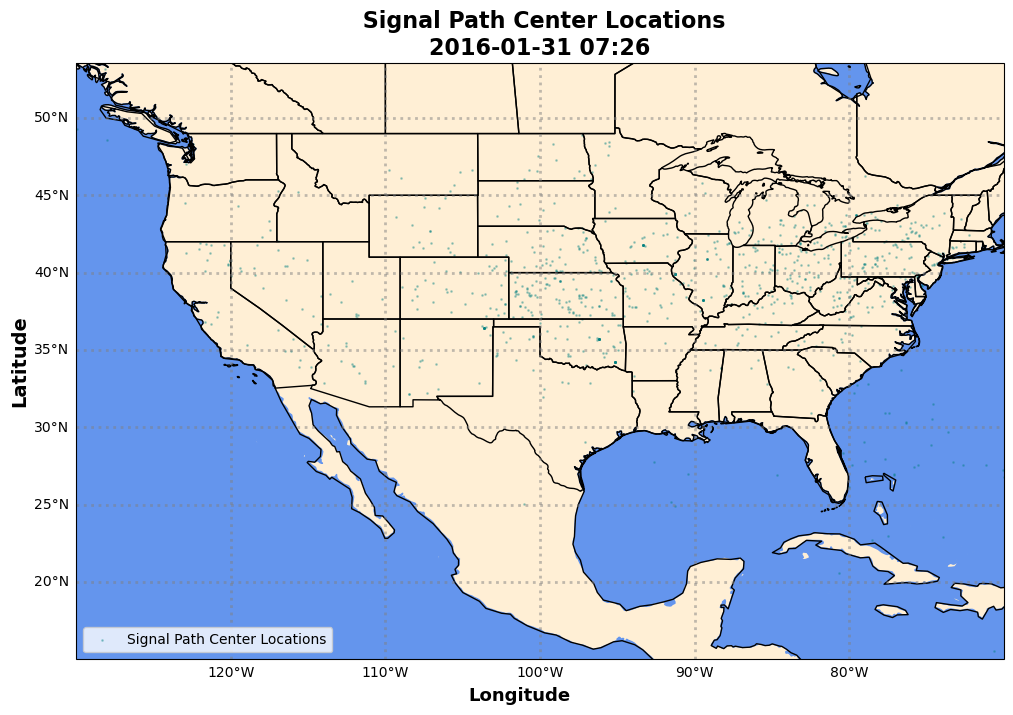

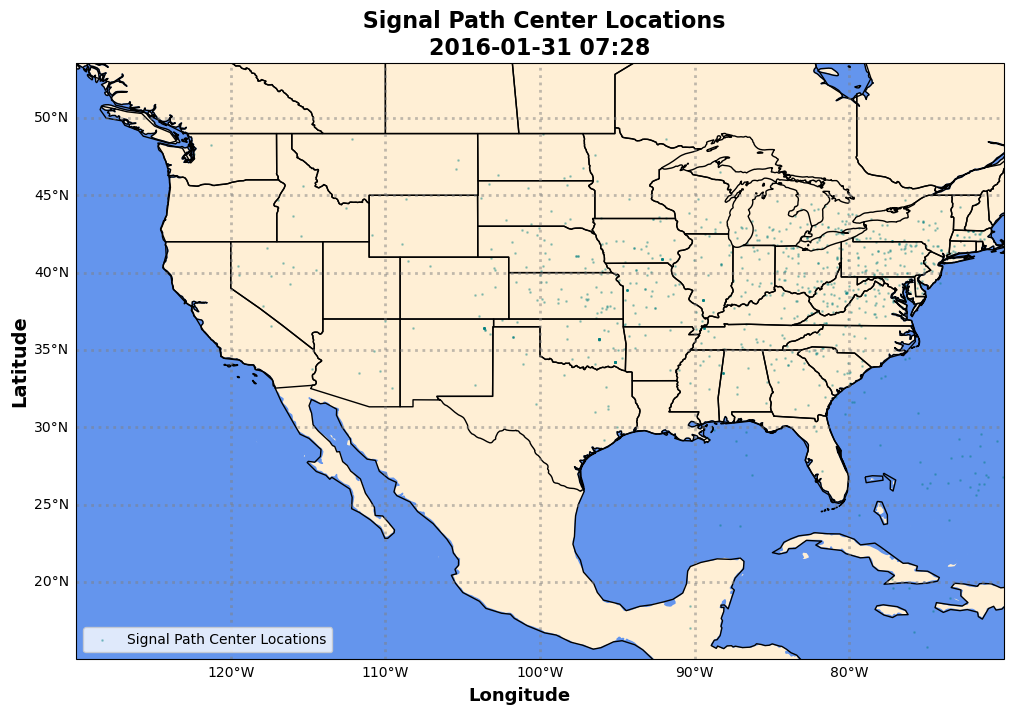

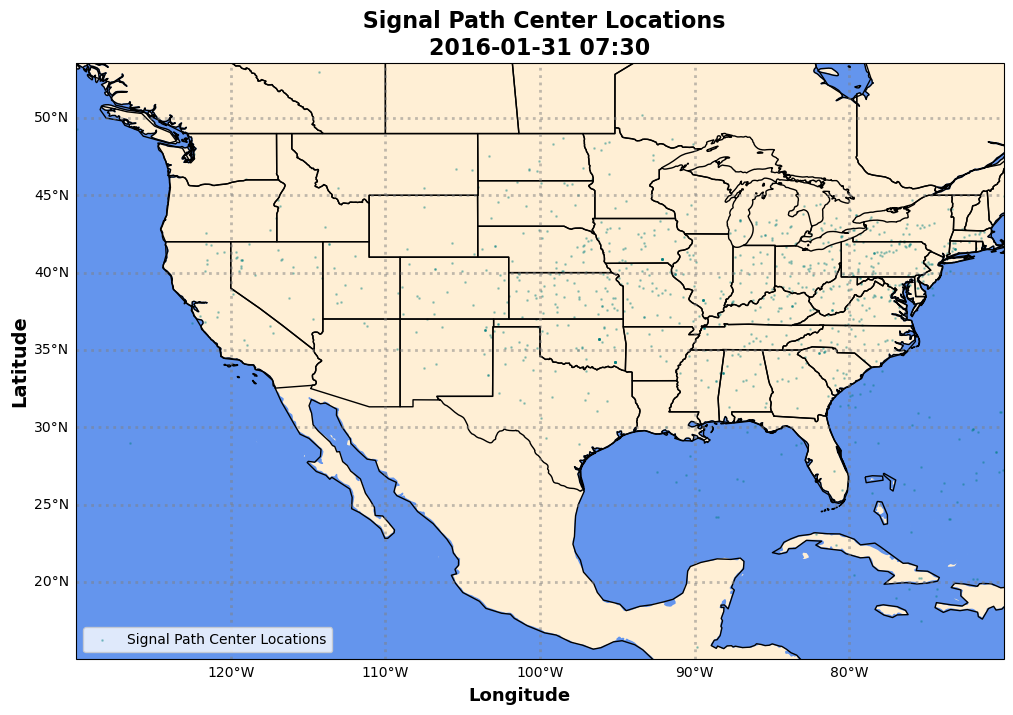

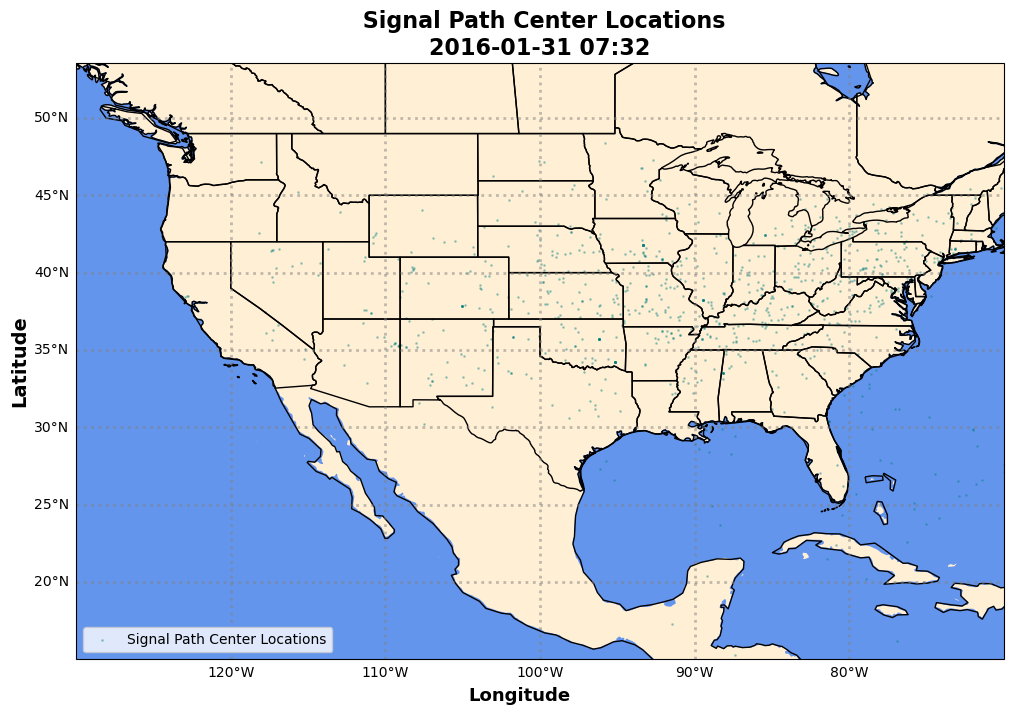

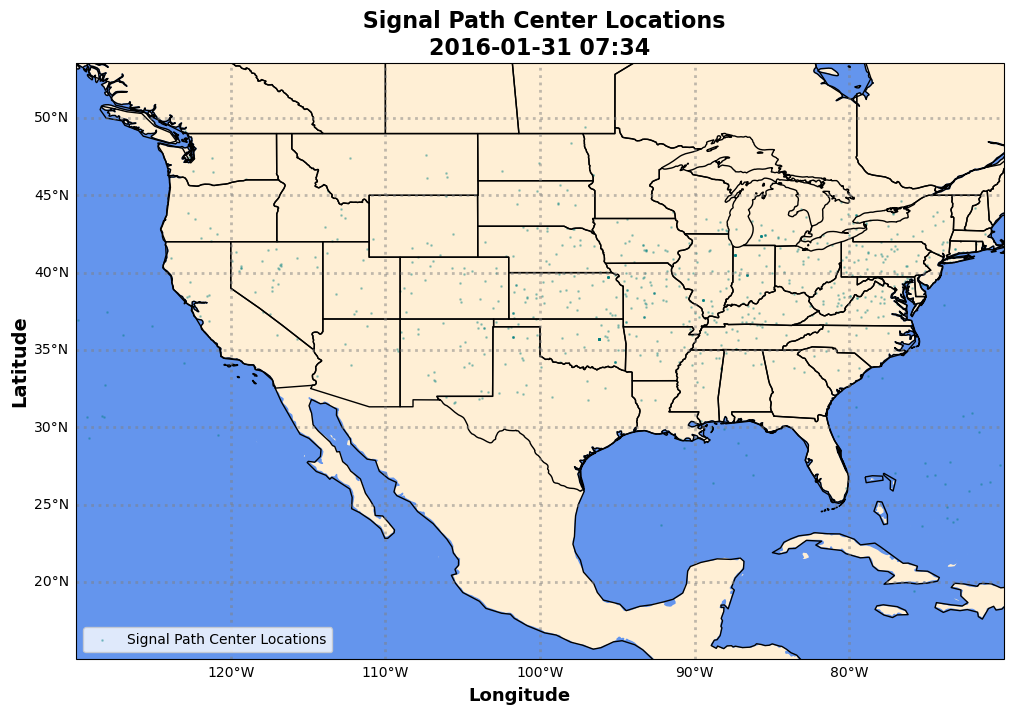

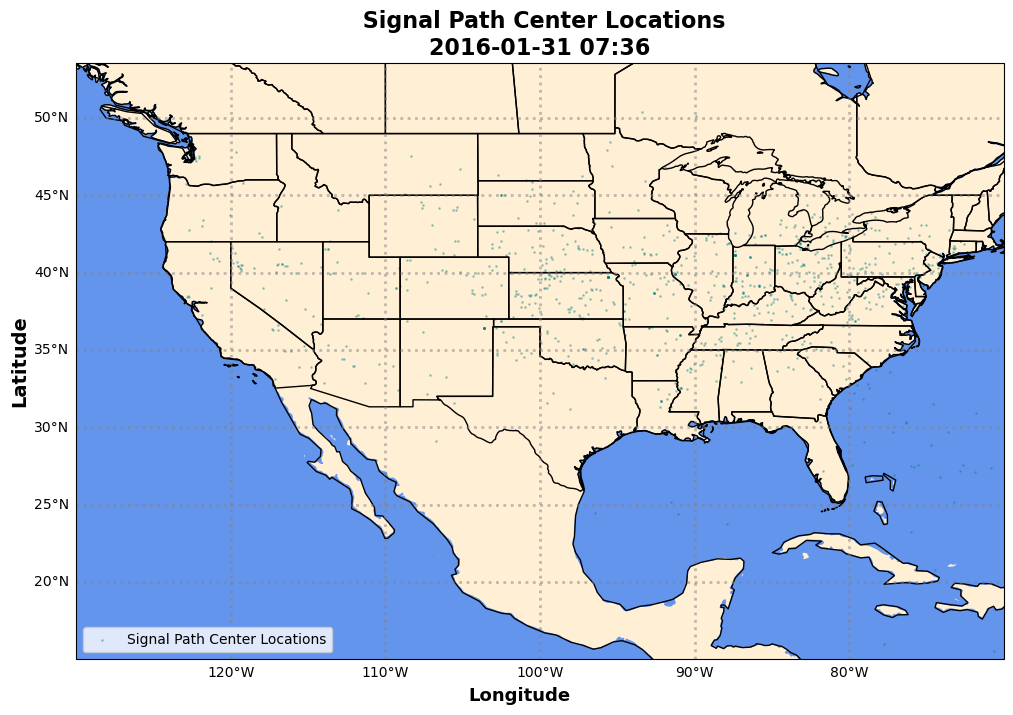

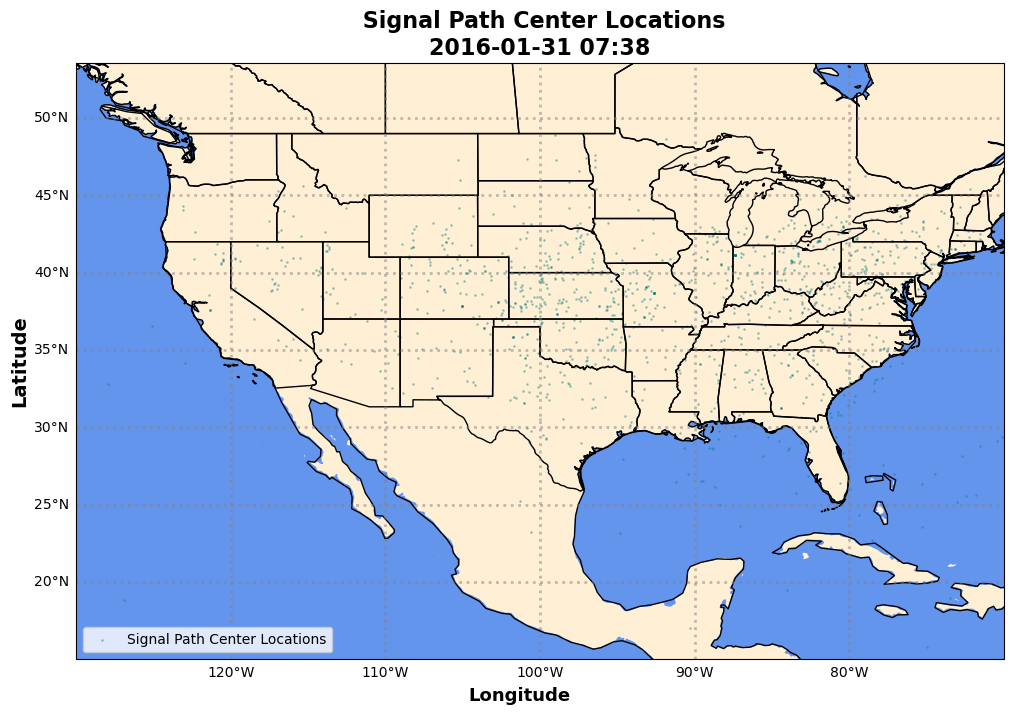

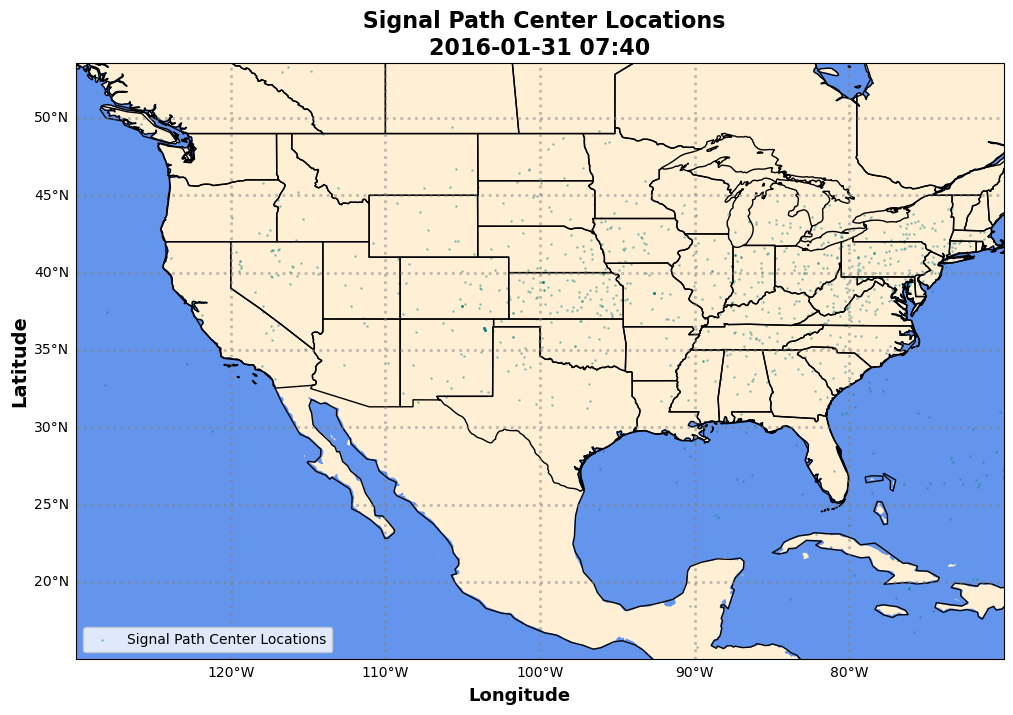

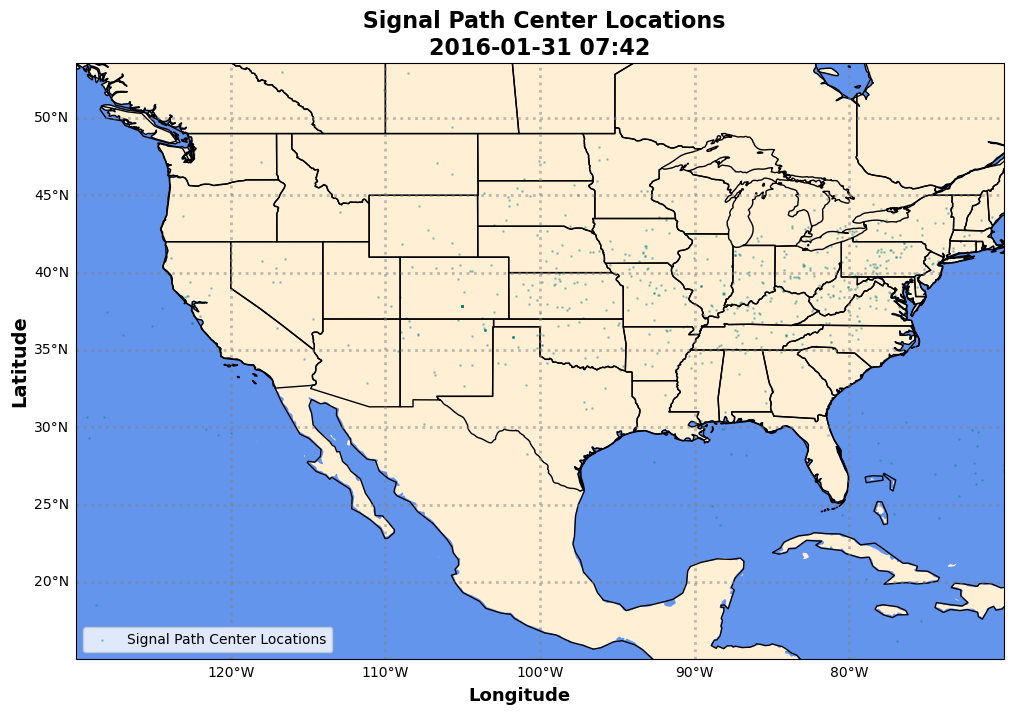

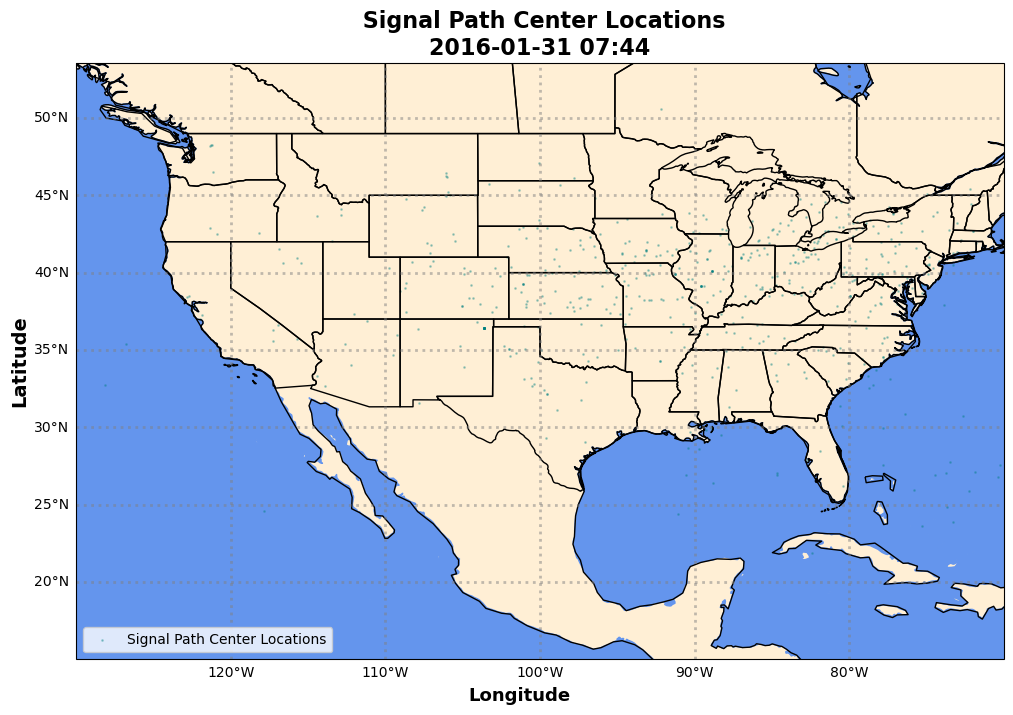

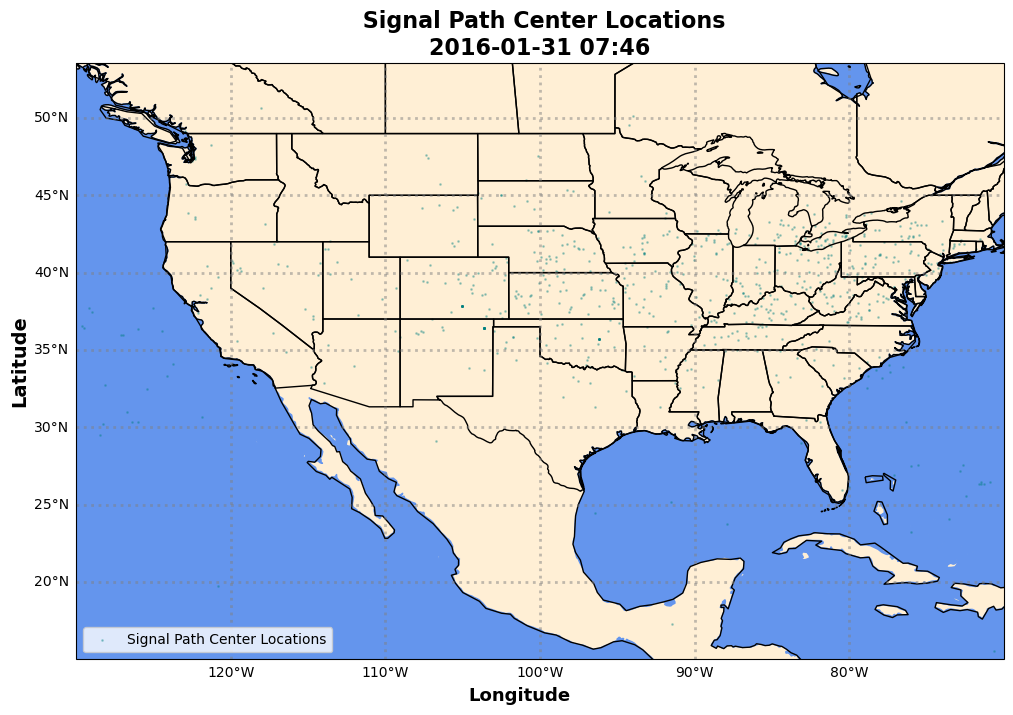

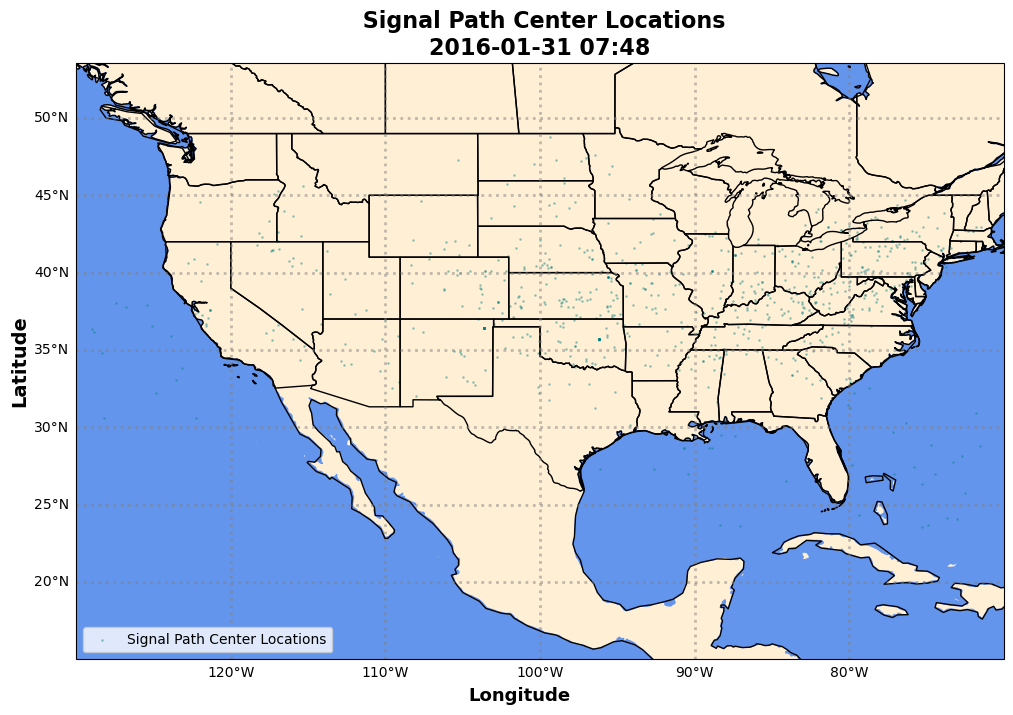

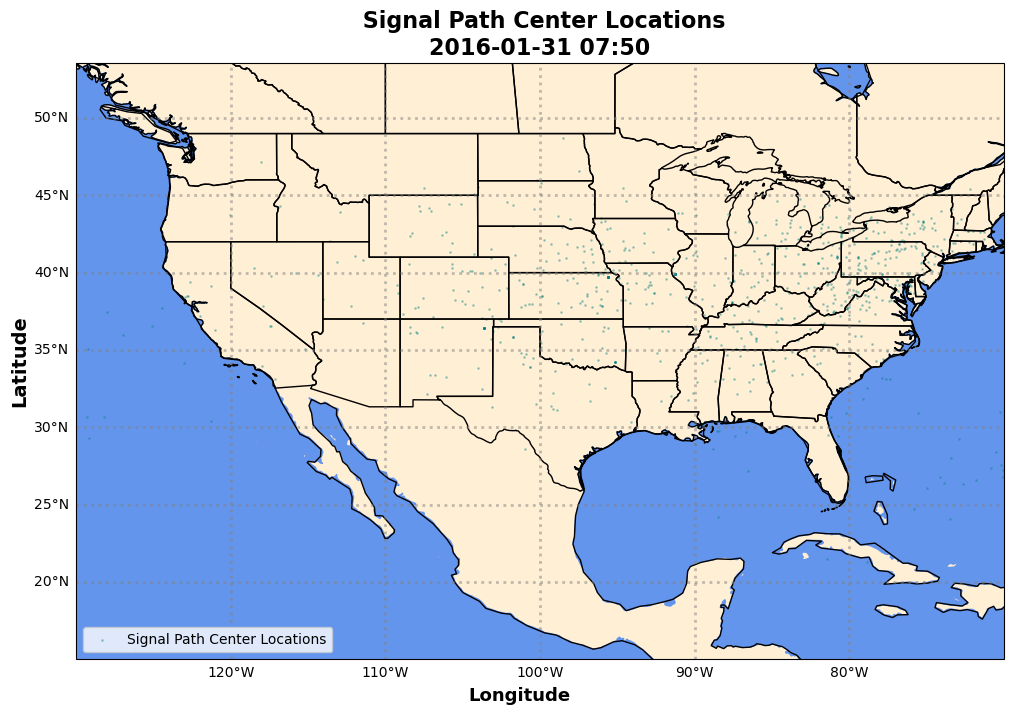

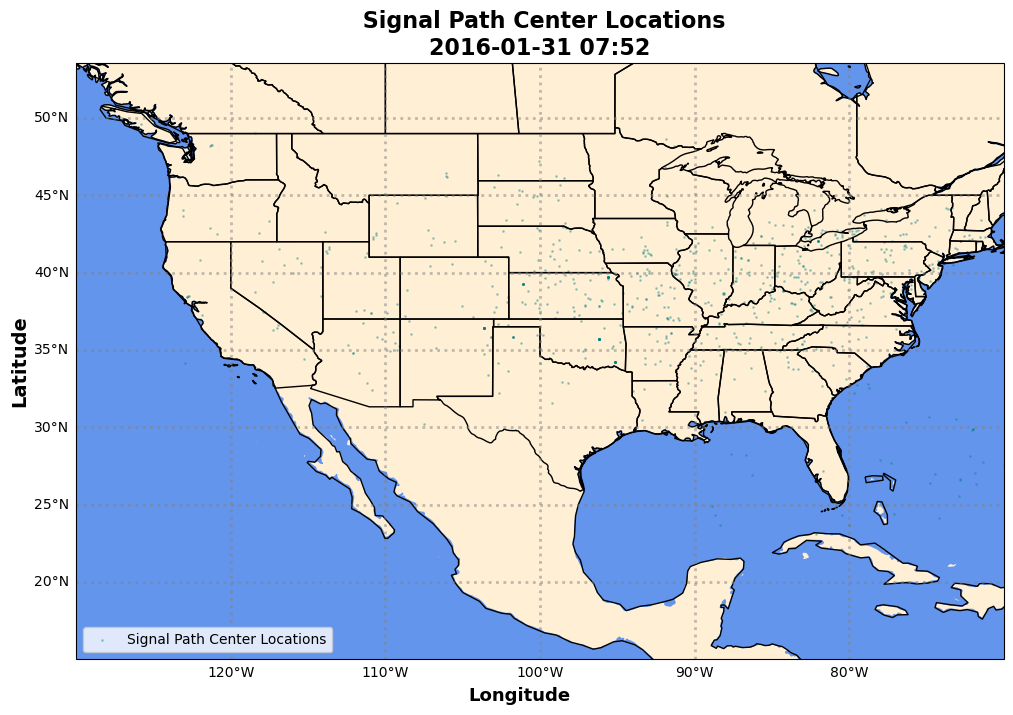

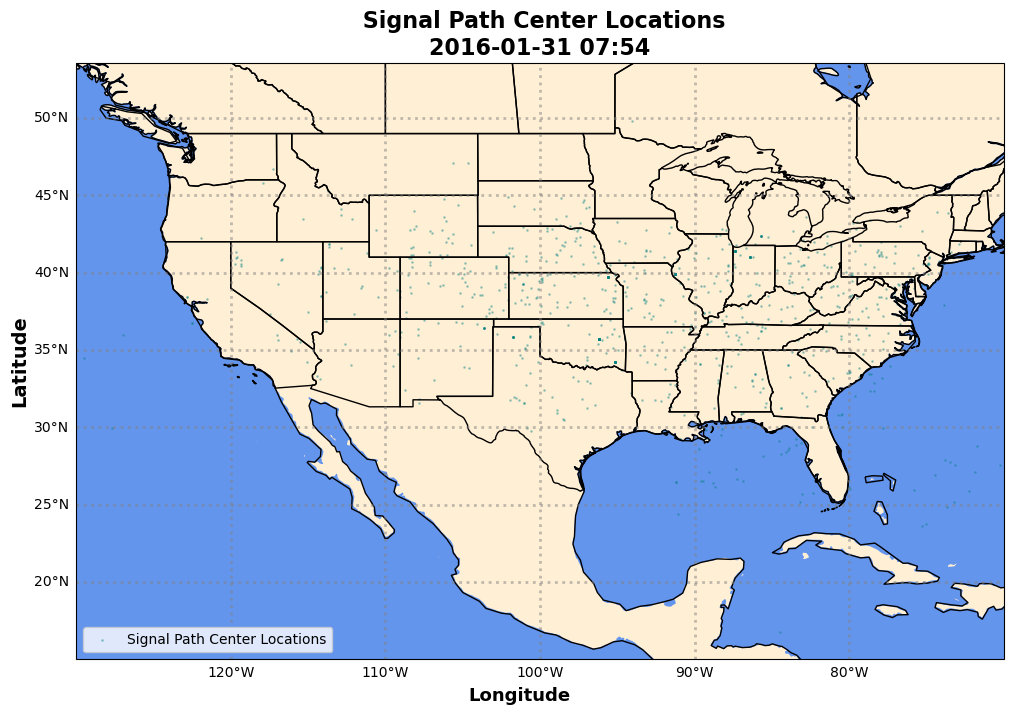

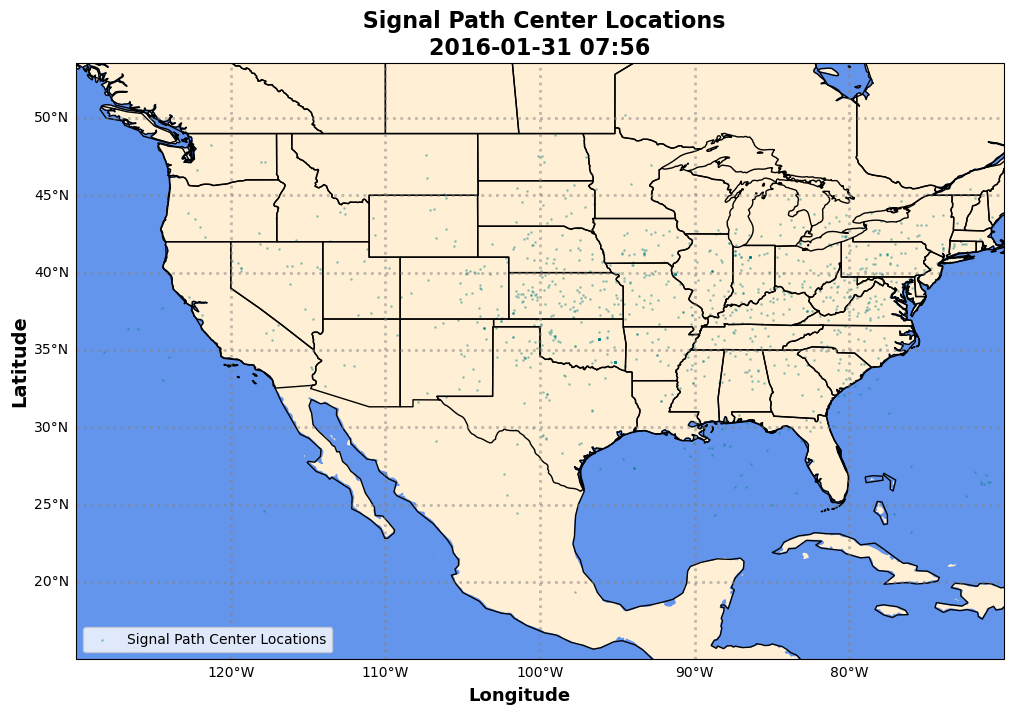

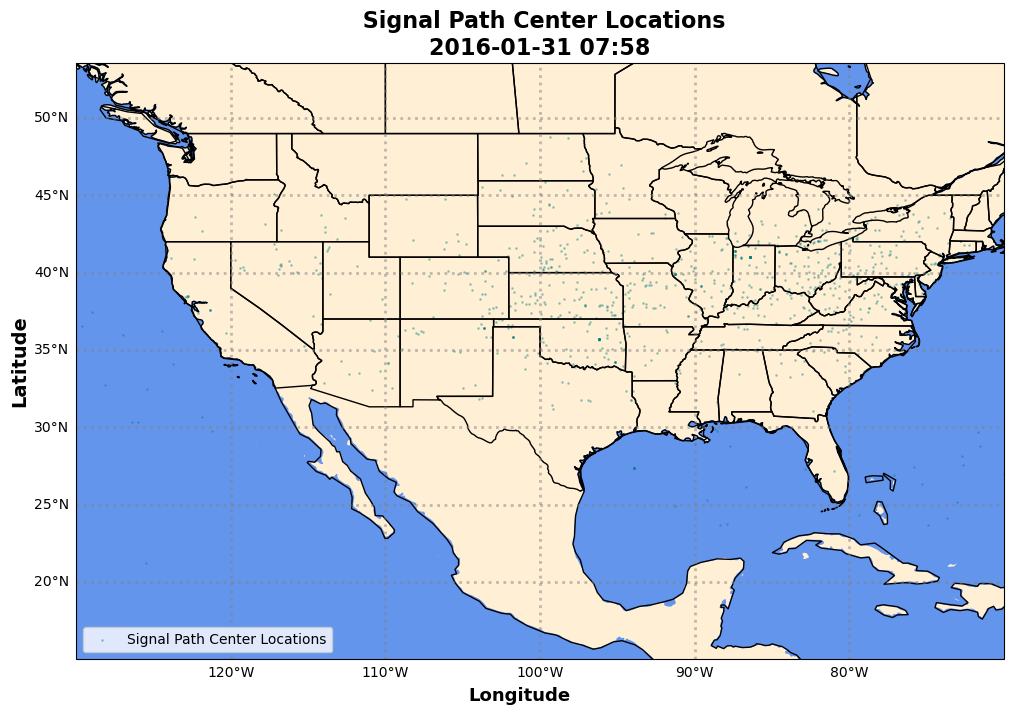

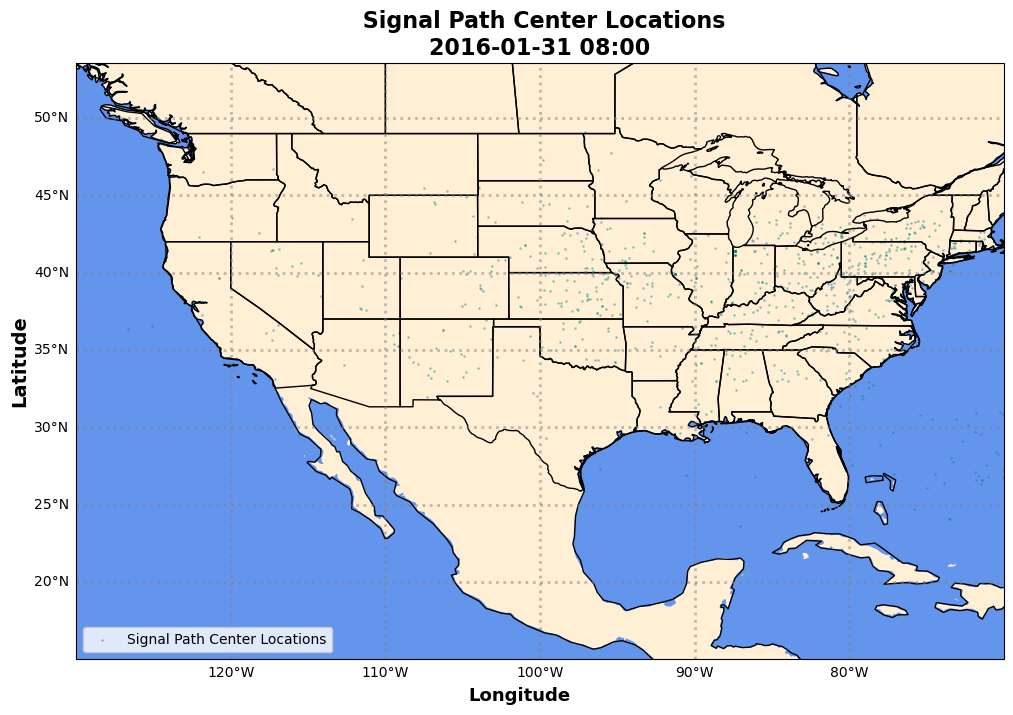

In [11]:
import h5py 
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import timedelta

#Cartopy imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Method responsible for loading and parsing hdf5 data
def loadDataConverter(filePath):
    with h5py.File(filePath, 'r') as f:
        datagroup = f['Data']
    with h5py.File(filePath, 'r') as f:
        dset = f['Data/Table Layout']
        rawdata = dset[:]
    df = pd.DataFrame(rawdata)

    #the following two lines were completed using chatgpt for upmost efficiency 
    for col in ['year', 'month', 'day', 'hour', 'min', 'sec']:
        df[col] = df[col].astype(str)

    #responsible for adding a new column to the dataframe
    df['Date&Time'] = pd.to_datetime(df['year'] + '-' + df['month'] + '-' + df['day'] + ' ' + df['hour'] + ':' + df['min'] + ':' + df['sec'], format = '%Y-%m-%d %H:%M:%S')

    return df.sort_values('Date&Time')

#Method responsible for plotting a Singal Map with LatCen and LonCen
def plotSignalMap(filteredData, currentTime, yData):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    extent = (-130,-70,15,50)
    ax.set_extent(extent)

    #Adds coastlines & appropriate features
    ax.coastlines(resolution = '110m', color = 'k')
    ax.add_feature(cfeature.LAND, color = 'papayawhip')
    ax.add_feature(cfeature.OCEAN, color = 'cornflowerblue')
    ax.add_feature(cfeature.STATES, edgecolor = 'k')

    #Add gridlines
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, linewidth = 2, color = 'gray', alpha = 0.5, linestyle = ':')
    gl.right_labels = False
    gl.top_labels = False

    #Plot Signal Locations
    if not filteredData.empty:
        ax.scatter(filteredData['loncen'], filteredData['latcen'], s = 1, alpha = 0.3, c = 'teal', transform = ccrs.PlateCarree(), label = 'Signal Path Center Locations')

    #Title/Labels & Legend
    fontProperties = {'fontsize': 16, 'fontweight': 'bold', 'color': 'black'}
    ax.set_title(f" Signal Path Center Locations\n{currentTime.strftime('%Y-%m-%d %H:%M')}", fontdict = fontProperties)
    # Adjusted axis labels for better positioning
    fig.text(-0.009, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.16, 'Longitude', ha='center', fontsize=13, fontweight='bold')

    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

#Method responsible for generating the data/graphing it
def generateFrames(df, startTime, endTime, interval, yData):
    currentTime = startTime + interval
    while currentTime <= endTime:
        filt = (df['Date&Time'] > currentTime - interval) & (df['Date&Time'] <= currentTime)
        filteredData = df[filt]
        plotSignalMap(filteredData, currentTime, yData)
        currentTime += interval
        
def main():
    filePath = '2016SampleData1.hdf5'
    #extracts the year 
    yData = filePath[0:4]

    df = loadDataConverter(filePath)

    #Time Range
    startTime = pd.Timestamp('2016-01-31 07:00:00')
    endTime = pd.Timestamp('2016-01-31 08:00:00')
    interval = timedelta(minutes = 2)

    generateFrames(df, startTime, endTime, interval, yData)

if __name__ == "__main__":
    main()